In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

In [3]:
DATA_FILE = '../input/spam.csv'
df = pd.read_csv(DATA_FILE,encoding='latin-1')

# drop extraneous columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
print(df.head())

labels = df.v1
messages = df.v2

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import time
from keras import metrics
print('\nimport done')

     v1                                                 v2
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

import done


In [4]:
# rename the column names to label and text
df = df.rename(columns={"v1": "label", "v2":"text"})
print(df.head())
df.label.value_counts()

  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


ham     4825
spam     747
Name: label, dtype: int64

In [5]:
df['msgLen'] = df['text'].map(lambda x:len(x))
print(df.describe())
mean = df['msgLen'].mean()
std = df['msgLen'].std()
print(mean)
print(std)
print("\n\nDetected outliers")

outlierCount = 0
for message in df['text']:
    # printing the length of the outliers, can comment out if desired
    if len(message) < mean - 2*std:
        print(len(message))
    elif len(message) > mean + 2*std:
        print(len(message))
    else:
        outlierCount -= 1
    outlierCount += 1
    
print("There were %d outliers" %outlierCount)

            msgLen
count  5572.000000
mean     80.118808
std      59.690841
min       2.000000
25%      36.000000
50%      61.000000
75%     121.000000
max     910.000000
80.11880832735105
59.6908407765031


Detected outliers
291
244
384
232
202
300
221
204
248
298
281
269
226
215
372
231
276
221
220
210
224
910
327
207
203
278
458
212
611
338
224
205
332
790
431
375
276
363
382
588
281
450
482
444
632
235
201
245
306
202
289
243
444
200
588
276
234
327
269
461
295
242
297
281
444
320
368
274
287
322
293
263
302
204
244
257
205
202
220
255
276
230
263
290
329
408
283
200
381
278
237
236
205
208
229
237
240
201
299
276
415
237
247
256
450
281
228
329
278
212
251
245
329
273
There were 114 outliers


In [6]:
spam = df[df.label == 'spam']
ham = df[df.label == 'ham']

from keras.preprocessing.text import text_to_word_sequence

def wordFreqs(text):
    msgs = {}
    for msg in text:
        words = text_to_word_sequence(msg)
        for word in words:
            # try and get more significant words
            if len(word) > 3:
                try:
                    msgs[word] += 1
                except:
                    msgs[word] = 1
    return msgs

spamDict = wordFreqs(spam.text)
hamDict = wordFreqs(ham.text)



In [7]:
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer
# # vectorizer = CountVectorizer()
# # vectorizer.fit(spam.text)

# spamVectorizer = TfidfVectorizer()
# spamVectorizer.fit(spam.text)
# spamDict = spamVectorizer.vocabulary_
# # print(vectorizer.vocabulary_)

# hamVectorizer = TfidfVectorizer()
# hamVectorizer.fit(ham.text)
# hamDict = hamVectorizer.vocabulary_

In [8]:
# Benchmark
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df["label"])

X_train,X_test,y_train,y_test = train_test_split(df["text"], y, test_size = 0.2, random_state = 10)
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
X_train_df = vectorizer.transform(X_train)
X_test_df = vectorizer.transform(X_test)

# lb = preprocessing.LabelBinarizer()
# lb.fit(y_train)

model = KNeighborsClassifier(n_neighbors=4)
model.fit(X_train_df, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

In [9]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn import preprocessing
prediction = model.predict(X_test_df)
print('Accuracy score: {}'.format(accuracy_score(y_test, prediction)))
print('F1 score: {}'.format(f1_score(y_test, prediction)))

Accuracy score: 0.9040358744394619
F1 score: 0.4455958549222798


<built-in method sum of numpy.ndarray object at 0x7f2801d13670>


Text(0.5,15,'Predicted label')

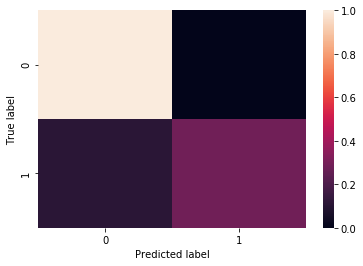

In [10]:
# referenced https://www.kaggle.com/futurist/text-preprocessing-and-machine-learning-modeling
from sklearn.metrics import confusion_matrix, classification_report
import seaborn
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, prediction)
print(cm.sum)
cm_norm = cm.astype('float') / cm.sum(axis=1)[np.newaxis]
seaborn.heatmap(cm_norm)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

spamWordcloud = WordCloud(width=600,height=400, max_words=1000,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(spamDict)
hamWordcloud = WordCloud(width=600,height=400, max_words=1000,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(hamDict)

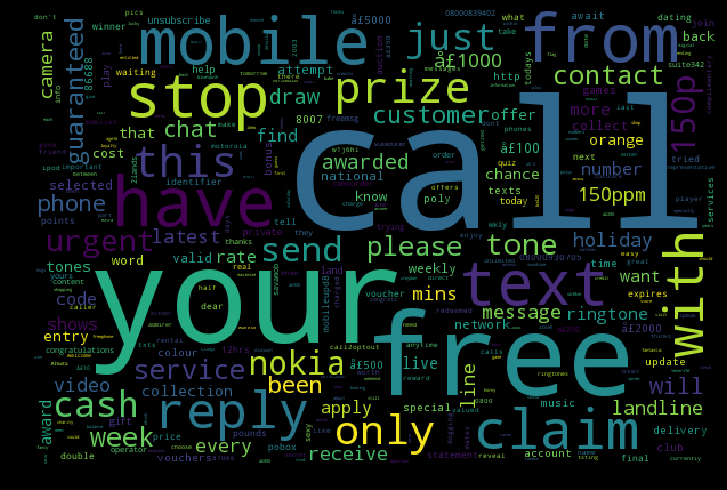

In [12]:
#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spamWordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

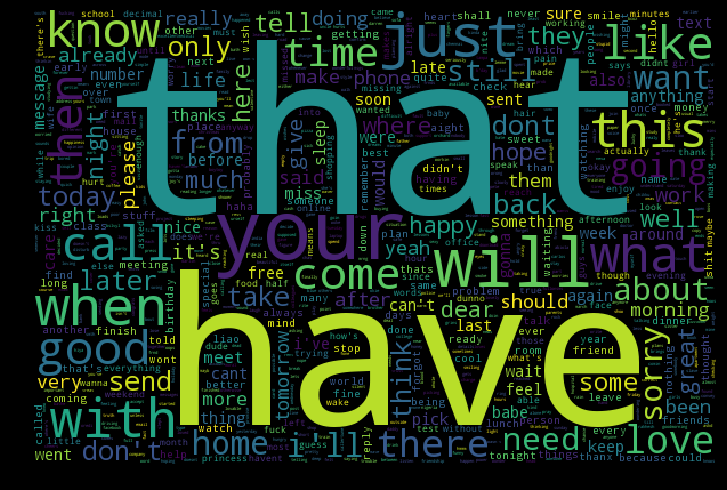

In [13]:
#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(hamWordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [14]:
max_words = 1000
num_max = max_words
# preprocess
le = LabelEncoder()
labels = le.fit_transform(labels)
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(messages)
mat_texts = tok.texts_to_matrix(messages,mode='count')
print(labels[:5])
print(mat_texts[:5])
print(labels.shape,mat_texts.shape)

[0 0 1 0 0]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  3. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  1. ...,  0.  0.  0.]]
(5572,) (5572, 1000)


In [16]:
# from iPython.display import clear_output
import keras
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
#         clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [20]:
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
#         clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               512512    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 644,097
Trainable params: 644,097
Non-trainable params: 0
_________________________________________________________________
Train on 4457 samples, validate on 1115 samples
Epoch 1/10
4416/4457 [============================>.] - ETA: 0s - loss: 0.1600 - acc: 0.

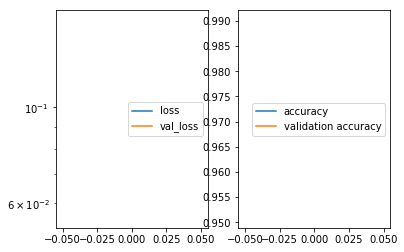

4457/4457 [==============================] - 4s 847us/step - loss: 0.1589 - acc: 0.9509 - binary_accuracy: 0.9509 - val_loss: 0.0555 - val_acc: 0.9901 - val_binary_accuracy: 0.9901
Epoch 2/10
4416/4457 [============================>.] - ETA: 0s - loss: 0.0306 - acc: 0.9916 - binary_accuracy: 0.9916

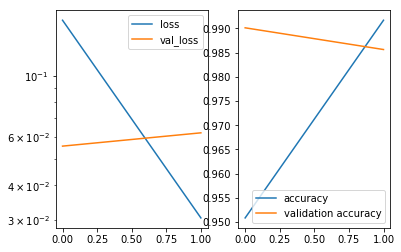

4457/4457 [==============================] - 4s 813us/step - loss: 0.0305 - acc: 0.9917 - binary_accuracy: 0.9917 - val_loss: 0.0620 - val_acc: 0.9857 - val_binary_accuracy: 0.9857
Epoch 3/10
4448/4457 [============================>.] - ETA: 0s - loss: 0.0091 - acc: 0.9971 - binary_accuracy: 0.9971

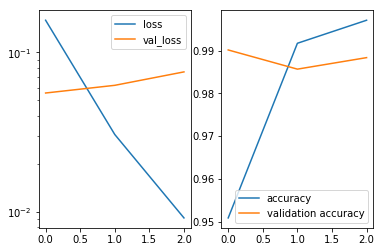

4457/4457 [==============================] - 4s 836us/step - loss: 0.0091 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0753 - val_acc: 0.9883 - val_binary_accuracy: 0.9883
Epoch 4/10
4320/4457 [============================>.] - ETA: 0s - loss: 0.0036 - acc: 0.9991 - binary_accuracy: 0.9991

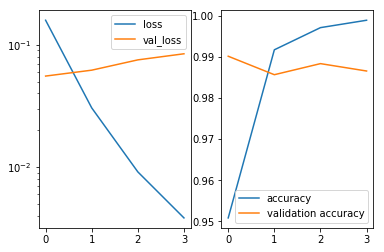

4457/4457 [==============================] - 4s 831us/step - loss: 0.0038 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0845 - val_acc: 0.9865 - val_binary_accuracy: 0.9865
Epoch 5/10
4448/4457 [============================>.] - ETA: 0s - loss: 0.0024 - acc: 0.9996 - binary_accuracy: 0.9996

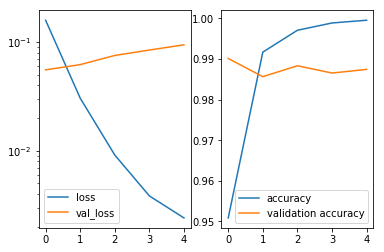

4457/4457 [==============================] - 4s 812us/step - loss: 0.0024 - acc: 0.9996 - binary_accuracy: 0.9996 - val_loss: 0.0944 - val_acc: 0.9874 - val_binary_accuracy: 0.9874
Epoch 6/10
4416/4457 [============================>.] - ETA: 0s - loss: 0.0021 - acc: 0.9995 - binary_accuracy: 0.9995    

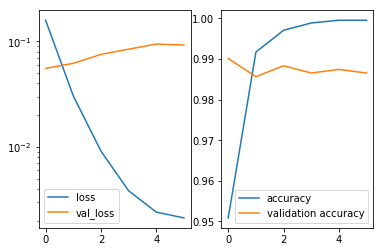

4457/4457 [==============================] - 4s 805us/step - loss: 0.0021 - acc: 0.9996 - binary_accuracy: 0.9996 - val_loss: 0.0925 - val_acc: 0.9865 - val_binary_accuracy: 0.9865
Epoch 7/10
4384/4457 [============================>.] - ETA: 0s - loss: 0.0019 - acc: 0.9998 - binary_accuracy: 0.9998

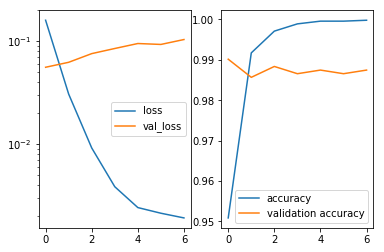

4457/4457 [==============================] - 4s 810us/step - loss: 0.0019 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.1032 - val_acc: 0.9874 - val_binary_accuracy: 0.9874
Epoch 8/10
4416/4457 [============================>.] - ETA: 0s - loss: 0.0014 - acc: 0.9998 - binary_accuracy: 0.9998

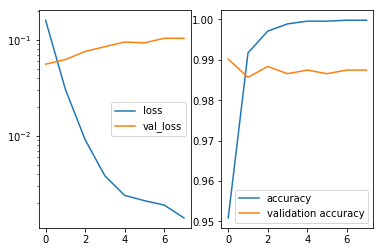

4457/4457 [==============================] - 4s 803us/step - loss: 0.0014 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.1033 - val_acc: 0.9874 - val_binary_accuracy: 0.9874
Epoch 9/10
4320/4457 [============================>.] - ETA: 0s - loss: 3.0965e-04 - acc: 1.0000 - binary_accuracy: 1.0000

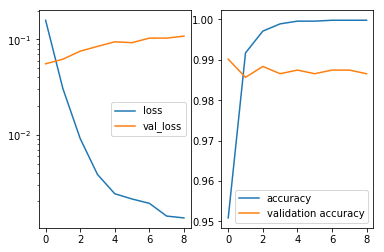

4457/4457 [==============================] - 3s 763us/step - loss: 0.0013 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.1083 - val_acc: 0.9865 - val_binary_accuracy: 0.9865
Epoch 10/10
4416/4457 [============================>.] - ETA: 0s - loss: 0.0013 - acc: 0.9998 - binary_accuracy: 0.9998

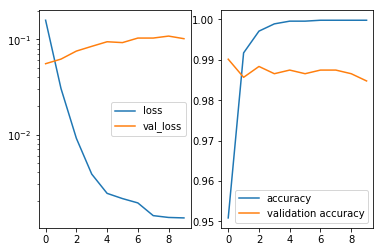

4457/4457 [==============================] - 3s 769us/step - loss: 0.0013 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.1017 - val_acc: 0.9848 - val_binary_accuracy: 0.9848


In [21]:
# try a simple model first
from keras import metrics

def get_simple_model():
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(num_max,)))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc',metrics.binary_accuracy])
    return model

def check_model(model,x,y):
#     print(x)
#     print(y)
    hist = model.fit(x,y,batch_size=32,epochs=10,verbose=1,validation_split=0.2,callbacks=[plot])

m = get_simple_model()
check_model(m,mat_texts,labels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               512512    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total para

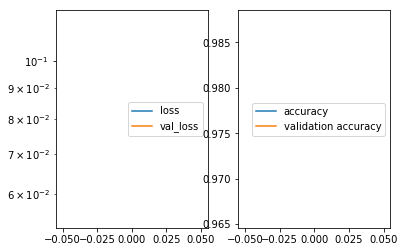

4457/4457 [==============================] - 3s 757us/step - loss: 0.1167 - acc: 0.9657 - binary_accuracy: 0.9657 - val_loss: 0.0548 - val_acc: 0.9874 - val_binary_accuracy: 0.9874
Epoch 2/10
4288/4457 [===========================>..] - ETA: 0s - loss: 0.0282 - acc: 0.9930 - binary_accuracy: 0.9930

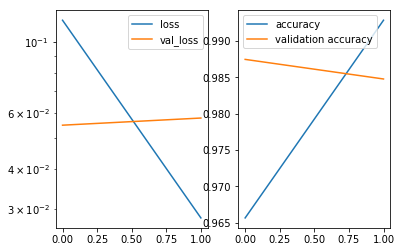

4457/4457 [==============================] - 3s 627us/step - loss: 0.0281 - acc: 0.9928 - binary_accuracy: 0.9928 - val_loss: 0.0577 - val_acc: 0.9848 - val_binary_accuracy: 0.9848
Epoch 3/10
4384/4457 [============================>.] - ETA: 0s - loss: 0.0115 - acc: 0.9968 - binary_accuracy: 0.9968

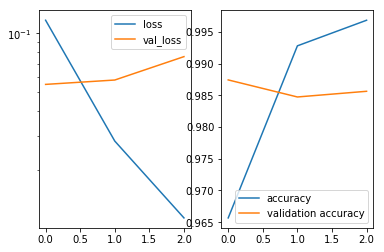

4457/4457 [==============================] - 3s 625us/step - loss: 0.0114 - acc: 0.9969 - binary_accuracy: 0.9969 - val_loss: 0.0760 - val_acc: 0.9857 - val_binary_accuracy: 0.9857
Epoch 4/10
4448/4457 [============================>.] - ETA: 0s - loss: 0.0047 - acc: 0.9991 - binary_accuracy: 0.9991

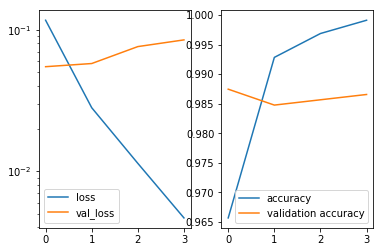

4457/4457 [==============================] - 3s 675us/step - loss: 0.0047 - acc: 0.9991 - binary_accuracy: 0.9991 - val_loss: 0.0848 - val_acc: 0.9865 - val_binary_accuracy: 0.9865
Epoch 5/10
4448/4457 [============================>.] - ETA: 0s - loss: 0.0030 - acc: 0.9991 - binary_accuracy: 0.9991- ETA: 1s - loss: 0.0028 - acc: 0.9986 - binary_accuracy: 0.99 - ETA: 1s - loss: 0.0025 - acc: 0.9988 - binary_accur

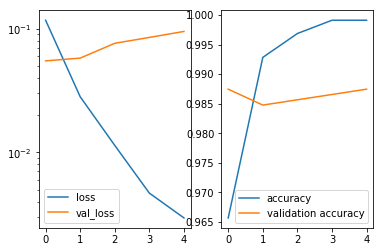

4457/4457 [==============================] - 3s 604us/step - loss: 0.0029 - acc: 0.9991 - binary_accuracy: 0.9991 - val_loss: 0.0948 - val_acc: 0.9874 - val_binary_accuracy: 0.9874
Epoch 6/10
4384/4457 [============================>.] - ETA: 0s - loss: 0.0024 - acc: 0.9998 - binary_accuracy: 0.9998

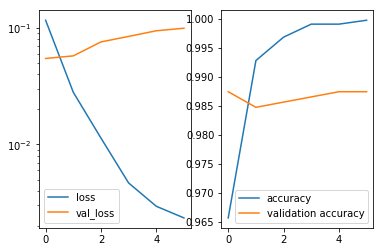

4457/4457 [==============================] - 3s 655us/step - loss: 0.0023 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.0997 - val_acc: 0.9874 - val_binary_accuracy: 0.9874
Epoch 7/10
4320/4457 [============================>.] - ETA: 0s - loss: 0.0019 - acc: 0.9998 - binary_accuracy: 0.9998

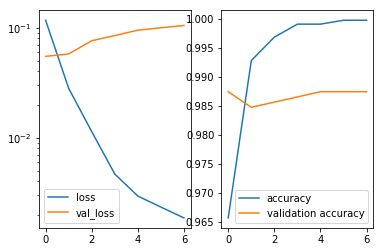

4457/4457 [==============================] - 3s 615us/step - loss: 0.0019 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.1046 - val_acc: 0.9874 - val_binary_accuracy: 0.9874
Epoch 8/10
4384/4457 [============================>.] - ETA: 0s - loss: 0.0021 - acc: 0.9998 - binary_accuracy: 0.9998   

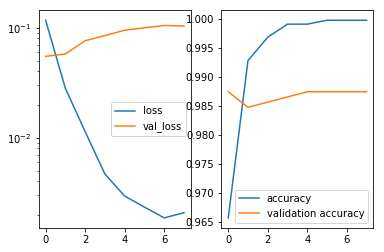

4457/4457 [==============================] - 3s 598us/step - loss: 0.0021 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.1034 - val_acc: 0.9874 - val_binary_accuracy: 0.9874
Epoch 9/10
4320/4457 [============================>.] - ETA: 0s - loss: 0.0017 - acc: 0.9998 - binary_accuracy: 0.9998- ETA: 1s - loss: 0.0040 - acc: 0.9994 - binary_

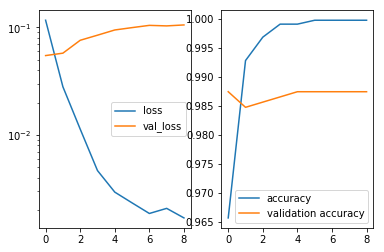

4457/4457 [==============================] - 3s 654us/step - loss: 0.0017 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.1056 - val_acc: 0.9874 - val_binary_accuracy: 0.9874
Epoch 10/10
4384/4457 [============================>.] - ETA: 0s - loss: 0.0016 - acc: 0.9998 - binary_accuracy: 0.9998    

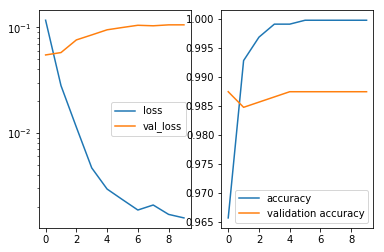

4457/4457 [==============================] - 3s 660us/step - loss: 0.0016 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.1056 - val_acc: 0.9874 - val_binary_accuracy: 0.9874


In [22]:
def get_model():
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(num_max,)))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
              optimizer='adagrad',
              metrics=['acc',metrics.binary_accuracy])
    return model

m = get_model()
check_model(m,mat_texts,labels)